In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler


In [25]:
def normalize_dataframe(df):
    """
    Normalizes all columns in a pandas DataFrame  using MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    scaler = MinMaxScaler()
    columns_to_normalize = [col for col in df.columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [26]:
def combine_csvs_from_folder(folder_path):
    """
    Combines all CSV files in a folder into a single pandas DataFrame also normalizes before combining them.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data from all CSV files in the input folder.
    """
    # Use a list comprehension to read all CSV files in the folder into a list of DataFrames.
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Use a list comprehension to get the filenames of all CSV files in the folder.
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(folder_path) if f.endswith('.csv')]

    processed_dfs = []
    i = 0
    for df, filename in zip(dfs, filenames):
        # Dont need the date column
        df = df.drop(['date'], axis=1)
        # normalize the dataframes before combining them
        #df = normalize_dataframe(df)
        # for the neural network to understand the company name we need to convert it to a number
        df['company'] = i
        i += 1
        processed_dfs.append(df)
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    return combined_df

df = combine_csvs_from_folder('market_data/merged_data')

df.tail()

,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,WMA,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,company
54006,7.152134e+08,5.281559e+06,11.5380,12.9553,1.7529,35.0,100.0,65.0,4.0997,228.1603,...,222.3566,229.00,230.05,226.83,227.66,227.66,5254725.0,0.0,1.0,10
54007,7.185228e+08,5.706147e+06,11.3947,12.5320,2.2713,30.0,95.0,65.0,3.9907,229.1161,...,223.0567,226.78,228.47,226.55,228.17,228.17,4813750.0,0.0,1.0,10
54008,7.197143e+08,5.740214e+06,10.9759,12.2622,2.3146,25.0,90.0,65.0,3.9657,229.6702,...,223.5208,226.16,226.73,224.68,225.99,225.99,4285206.0,0.0,1.0,10
54009,7.244374e+08,6.735109e+06,10.5243,12.1557,2.5636,20.0,85.0,65.0,3.8754,230.0872,...,223.9982,225.56,226.48,224.32,226.43,226.43,4952351.0,0.0,1.0,10
54010,7.268322e+08,7.291812e+06,10.4633,12.0796,2.8719,15.0,80.0,65.0,3.8286,230.4999,...,224.6191,227.00,229.14,226.20,228.45,228.45,4513284.0,0.0,1.0,10


In [27]:
#we need this for later
def find_indices_of_last_company_changes(df):
    indices = []
    for i in range(1, len(df)):
        if df.loc[i, 'company'] != df.loc[i - 1, 'company']:
            indices.append(i-1)
    return indices
idxs = find_indices_of_last_company_changes(df)
idxs.append(len(df) - 1)



In [28]:
# we should one hot encode the company column
# first we need to change it to a string so we can one hot encode it
df['company'] = df['company'].astype(str)
df = pd.get_dummies(df, columns=['company'])

In [29]:
def add_up_column(df):
    # Create empty 'up' and 'down' columns
    df['up'] = 0
    
    # Loop over the rows (skipping the first row)
    for i in range(1, len(df)):
        if df.loc[i, '4. close'] > df.loc[i-1, '4. close']:
            df.loc[i, 'up'] = 1
    return df


df = add_up_column(df)
df.head()


,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,company_10,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,up
0,-4.307458e+08,-2.790035e+08,15.0266,13.1844,-0.0123,95.0,25.0,-70.0,0.0673,1.1249,...,0,0,0,0,0,0,0,0,0,0
1,-6.725731e+08,-3.547090e+08,15.5542,13.4513,-0.0245,90.0,20.0,-70.0,0.0673,1.1317,...,0,0,0,0,0,0,0,0,0,0
2,-2.668645e+08,-2.243441e+08,15.5362,13.8272,-0.0252,85.0,15.0,-70.0,0.0696,1.1316,...,0,0,0,0,0,0,0,0,0,1
3,1.240607e+08,-2.623278e+07,15.2820,14.2793,-0.0324,80.0,10.0,-70.0,0.0690,1.1274,...,0,0,0,0,0,0,0,0,0,1
4,-2.603556e+08,-6.511672e+07,14.7776,14.7198,-0.0422,75.0,5.0,-70.0,0.0695,1.1107,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# neural networks require tensors, so we need to convert our dataframes to tensors

def df_to_tensor(df):
    inputs_columns = df.columns[df.columns != 'up']
    inputs = torch.from_numpy(df.loc[:, inputs_columns].values.astype('float32'))
    targets = torch.from_numpy(df.loc[:, ['up']].values.astype('float32'))
    return inputs, targets


inputs, targets = df_to_tensor(df)
print(inputs[0])
print(inputs.shape)
print(targets.shape)

tensor([-4.3075e+08, -2.7900e+08,  1.5027e+01,  1.3184e+01, -1.2300e-02,
         9.5000e+01,  2.5000e+01, -7.0000e+01,  6.7300e-02,  1.1249e+00,
         9.8730e-01,  8.4980e-01,  2.0090e-01, -1.5646e+02, -1.0042e+01,
         9.4590e-01,  2.5578e+01,  9.5160e-01,  1.5876e+01, -9.9100e-01,
        -2.7000e-02, -8.9000e-03, -1.7300e-02,  6.9480e-01,  9.9630e-01,
         1.0000e+00,  9.2300e-01, -1.1000e-02,  1.2200e-02, -2.3200e-02,
        -1.2300e-02,  3.0400e-02, -4.2700e-02,  5.6220e-01,  1.3320e-01,
         5.4206e+01,  9.6290e-01,  9.6970e-01,  2.5903e+01,  3.4830e-01,
        -5.8900e-02,  7.7768e+00,  7.8613e+09,  1.5351e+01,  2.0640e-01,
        -1.2678e+00, -6.3755e+00,  9.3620e-01,  4.4979e+01,  1.1211e+00,
         9.8730e-01,  1.8414e+01,  2.7301e+01,  3.2066e+01,  1.8414e+01,
         2.2685e+01,  7.5618e+00,  1.0122e+00,  9.0810e-01,  8.7400e-02,
         1.0052e+00,  3.6670e-01,  4.1021e+01, -8.0356e+01,  9.6420e-01,
         1.1150e+02,  1.2000e+02,  1.0850e+02,  1.1

In [31]:
def create_sequences(inputs, targets, seq_length):
    seq_inputs = []
    seq_targets = []
    for i in range(len(inputs) - seq_length):
        seq_inputs.append(inputs[i:i + seq_length])
        seq_targets.append(targets[i + seq_length])
    return torch.stack(seq_inputs), torch.stack(seq_targets)

sequence_length = 10
seq_inputs, seq_targets  = create_sequences(inputs, targets, sequence_length)

In [32]:
# making a training and validation dataset

dataset = TensorDataset(seq_inputs, seq_targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [33]:
# pytorch uses dataloaders to load data in batches

batch_size = 256
train_loader = DataLoader(dataset, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, 12, shuffle = False, num_workers = 0)

In [34]:
# use gpu if avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class LSTM_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# input size is 84 because we have 84 columns in our dataframe
# output size is 1 because we are predicting up=1 or down=0
input_size = 84
output_size = 1
hidden_size = 256
num_layers = 5
model = LSTM_NN(input_size, hidden_size, num_layers, output_size)
model.to(device)

LSTM_NN(
  (lstm): LSTM(84, 256, num_layers=5, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
# hyperparameters for training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100

In [14]:
# training loop
training_losses = []
sequence_length = 10
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.view(-1, sequence_length, input_size)
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #average the loss over all batches
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    if(epoch % 10 == 0 or epoch == 1):
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')

epoch: 1, avg_loss: 0.6928209913850396
epoch: 10, avg_loss: 0.6905814561798674
epoch: 20, avg_loss: 0.6826905924562029
epoch: 30, avg_loss: 0.6451379679390604
epoch: 40, avg_loss: 0.5289174226505496
epoch: 50, avg_loss: 0.36504797079551843
epoch: 60, avg_loss: 0.22879056159353933
epoch: 70, avg_loss: 0.13362696117134457
epoch: 80, avg_loss: 0.06961475897103689
epoch: 90, avg_loss: 0.05431623856638563
epoch: 100, avg_loss: 0.03821887758282406


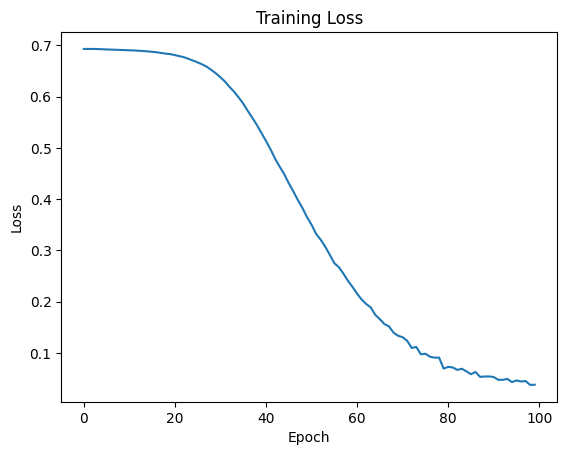

In [15]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [16]:
def validate(model, dataloader, criterion):
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    flag = 0
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs = inputs.view(-1, sequence_length, input_size)
            inputs, targets = inputs.to(device), targets.to(device) # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, targets.float()) # BCE loss expects float inputs
            val_loss += loss.item() * inputs.size(0) # Track total validation loss
            
            # Calculate accuracy
            if flag == 0:
                print(targets.view(-1))
                print(torch.round(outputs.view(-1)))
                flag = 1
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(dataloader.dataset)
    accuracy = correct / total
    
    return val_loss, accuracy

val_loss, val_acc = validate(model, val_loader, criterion)
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
val_loss: 0.031178818218975595, val_acc: 0.9900009258401999


In [19]:
#not yet working for LSTM model

# how will visa do tomorrow? > 0.5 = up, < 0.5 = down
inputs, targets = df_to_tensor(df)
inputs = inputs.to(device)
model(inputs[len(inputs)-10:len(inputs)-1])

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [35]:
seq_inputs[len(seq_inputs)-1]

tensor([[ 7.0454e+08,  3.4130e+06,  1.3240e+01,  1.4752e+01, -1.3363e+00,
          6.5000e+01,  2.5000e+01, -4.0000e+01,  4.2177e+00,  2.2580e+02,
          2.1997e+02,  2.1413e+02, -2.9000e-01,  6.4738e+01,  3.2373e+00,
          2.1975e+02,  1.9591e+00,  2.2054e+02,  1.8489e+01,  6.4948e+01,
          1.2391e+00,  2.7758e+00,  9.0590e-01,  9.4000e-01,  2.1992e+02,
          1.0000e+00,  2.2164e+02, -4.2300e-01, -9.1090e-01,  4.8790e-01,
         -1.3363e+00, -2.0512e+00,  7.1490e-01,  2.1227e+02,  2.0731e+02,
          6.0415e+01,  2.2061e+02,  2.1809e+02,  2.3910e+01,  2.0169e+01,
          1.4600e+00,  1.9015e+00,  3.1344e+09,  2.2991e+01,  1.9394e+01,
         -6.0690e-01,  6.6260e-01,  1.0066e+00,  5.1619e+01,  2.0957e+02,
          2.1997e+02,  5.8390e+01,  6.7733e+01,  5.0857e+01,  5.8390e+01,
          6.6700e+01,  7.7107e+01,  2.2131e+02,  2.1959e+02,  3.0400e+00,
          2.1921e+02, -2.9600e-02,  4.8769e+01, -3.0046e+01,  2.1984e+02,
          2.2259e+02,  2.2408e+02,  2.

In [ ]:
filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir("market_data/merged_data/") if f.endswith('.csv')]

for i, idx in enumerate(idxs):
    print(f"{filenames[i]}: {model(inputs[idx]).item():.2f}")
